# Support Vector Regression
### *Exploring the association between neoantigen-related variables and immune scores*
This notebook is the continuation of the `xgboost_tuned.ipynb` notebook, detailing the testing of SVR application on our neoantigen dataset.

#### **Package and Raw Data Loading**
First, import necessary packages and load in the raw data table into `pandas` dataFrame. 



In [102]:
# first, import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from feature_engine.transformation import YeoJohnsonTransformer

from itables import show
from IPython.display import HTML, display
from warnings import simplefilter, filterwarnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

# load pretty jupyter's magics
%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


Load up the cleaned-up dataset wrangled from MH's latest work.

In [103]:
# read in latest data
# use the 202409_new_excludedIHC_batch-duplicate-removed.tsv
df = pd.read_csv("../input-data/SA/202409_new_excludedIHC_batch-duplicate-removed.tsv",sep="\t")
print(f"Before trimming columns: {df.shape}")

# exclude the 29 Cibersort scores, leaving only 3
df = df.drop(columns=['Bindea_full', 'Expanded_IFNg', 
        'C_Bcellsmemory','C_Plasmacells','C_TcellsCD8','C_TcellsCD4naive',
         'C_TcellsCD4memoryactivated','C_Tcellsfollicularhelper',
         'C_Tcellsregulatory(Tregs)','C_Tcellsgammadelta','C_NKcellsresting',
         'C_NKcellsactivated', 'C_Monocytes', 'C_MacrophagesM0',
         'C_MacrophagesM1','C_Dendriticcellsresting',
         'C_Dendriticcellsactivated', 'C_Mastcellsresting',
         'C_Mastcellsactivated','C_Eosinophils', 'C_Neutrophils', 'S_PAM100HRD'])

print(f"After trimming columns: {df.shape}")
df.head()

Before trimming columns: (953, 156)
After trimming columns: (953, 134)


,ID,Batch,PAM50,Subtype,HR_status,HER_status,Age,AgeGroup,Stage,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestScore,FusionTransscript_Count,Fusion_T2NeoRate,SNVindelNeo_Count,SNVindelNeo_IC50,SNVindelNeo_IC50Percentile,TotalNeo_Count,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
0,SD0012,Batch_1,LumB,HR+/HER2-,HR+,HER2-,50.0,41-50,2.0,2.0,2.3,20.0,5.79,42.0,0.476190476,357.0,1.7,0.0025,377.0,2895.605487,9.0,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
1,SD0014,Batch_1,LumA,HR+/HER2-,HR+,HER2-,58.0,51-60,2.0,2.0,2.5,10.0,5.28,17.0,0.588235294,85.0,4.1,0.0039,95.0,4257.831526,11.0,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.27

#### **Data Preprocessing**

Decide all the clinical variables and neoantigen-related variables to keep in the X matrix (features).

1. `Subtype` column has already been encoded categorically by `HR_status` and `HER_status` columns so these two columns can be dropped. ***UPDATE: due to their lesser importance during the default XGBoost modeling, `PAM50` column was dropped as well.***

2.  `AgeGroup` is just a binned information of `Age` column so it is dropped as it is redundant.

3. Drop `FusionNeo_bestScore`, `FusionTransscript_Count`, `Fusion_T2NeoRate` columns as well as the `SNVindelNeo_IC50` and `SNVindelNeo_IC50Percentile` columns for now to reduce complexity.

4. Drop `Batch` column.

> **UPDATE 1: Exclude `TotalNeo_Count`, and include `Fusion_T2NeoRate` and `SNVindelNeo_IC50` columns. Also, rename `Fusion_T2NeoRate` to `FN/FT_Ratio`.**

> **UPDATE 2: put back `FusionNeo_bestScore` into the X variable set and rename it into `FusionNeo_bestIC50`**

In [104]:
# let's drop all NaN for now and set col 'ID' as index
dfd = df.drop(columns = ['Batch', 'Stage', 'PAM50', 'HR_status', 'HER_status', 'AgeGroup', 'TotalNeo_Count', 'FusionTransscript_Count', 'SNVindelNeo_IC50Percentile']).dropna().set_index('ID')

# rename the column `Fusion_T2NeoRate` to `FN/FT_Ratio` and `FusionNeo_bestScore` to `FusionNeo_bestIC50`
dfd.rename(columns={'Fusion_T2NeoRate': 'FN/FT_Ratio'}, inplace=True)
dfd.rename(columns={'FusionNeo_bestScore': 'FusionNeo_bestIC50'}, inplace=True)

print(dfd.shape)
dfd.head()

(674, 124)


,Subtype,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,HR+/HER2-,50.0,2.0,2.3,20.0,5.79,0.476190476,357.0,1.7,2895.605487,9.0,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,HR+/HER2-,58.0,2.0,2.5,10.0,5.28,0.588235294,85.0,4.1,4257.831526,11.0,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,HR+/HER2-,46.0,2.0,1.8,4.0,11.48,0.25,150.0,2.4,3

**Sanity Check:** Check to make sure there is no duplicated index rows in the dataset.

In [105]:
print(dfd.index[dfd.index.duplicated()].unique())
rows_dupe = list(dfd.index[dfd.index.duplicated()].unique())
rows_dupe

Index([], dtype='object', name='ID')


[]

Now, We need to encode the `object` columns of `Subtype` and `FN/FT_Ratio` into appropriate types. Change `Age`, `TumorGrade`, and `IMPRES` into `int64` as well as all `*_Count` columns because they are discrete variables. Change the `FN/FT_Ratio` into `float64`.

In [106]:
dfd['Subtype'] = dfd['Subtype'].astype('category')
dfd['Age'] = dfd['Age'].astype('int64')
dfd['TumorGrade'] = dfd['TumorGrade'].astype('int64')
dfd['IMPRES'] = dfd['IMPRES'].astype('int64')
dfd['FusionNeo_Count'] = dfd['FusionNeo_Count'].astype('int64')
dfd['SNVindelNeo_Count'] = dfd['SNVindelNeo_Count'].astype('int64')
dfd['FN/FT_Ratio'] = dfd['FN/FT_Ratio'].astype('float64')

# print(dfd.dtypes)
pd.set_option('display.max_rows', 8)

Now we can use Feature_Engine's `OneHotEncoder()` to create a `k` dummy variable set for `Subtype`.

**NOTE**: The encoded columns will be appended at the end of the dataFrame. 


In [107]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(
    variables=['Subtype'],
    drop_last=False)

encoder.fit(dfd)
dfd_ = encoder.transform(dfd)
dfd_.head()

,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530,1,0,0,0
SD0014,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606,1,0,0,0
SD0015,46,2,1.8,4,11.48,

In [108]:
# Specify the encoded columns to shift
enc_cols = ['Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']

# Drop the specified columns and store them
encoded_df = dfd_[enc_cols]
dfenc = dfd.drop(columns=['Subtype'])

# Specify the index where you want to reinsert the columns
insert_index = 0  # This will insert at the first column

# Reinsert the columns
for i, col in enumerate(encoded_df.columns):
    dfenc.insert(insert_index + i, col, encoded_df[col])

Below is the categorically-encoded dataframe.

In [109]:
print(dfenc.shape)
dfenc.head()

(674, 127)


,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,1,0,0,0,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,1,0,0,0,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,1,0,0,0,46,2,1.8,

And below is the original, unencoded dataframe.

In [110]:
print(dfd.shape)
dfd.head()

(674, 124)


,Subtype,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,HR+/HER2-,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,HR+/HER2-,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,HR+/HER2-,46,2,1.8,4,11.48,0.250000,150,2.4,3123.055856,8,0.162653,0.235337

#### **Subsetting Y Labels**

In the previous exploration, many of the immune scores (Y targets/labels) might not really show much relationship with fusion neoantigen variables so they may not be as informative. We decided to use Caitlin's finding and subset the Y labels into several clinically meaningful groups.

In [111]:
# use the unencoded categorical dataframe (dfd) and drop the Subtype categorical column
df_dcat = dfd.drop(columns=['Subtype'])
print(df_dcat.shape)
df_dcat.head()

(674, 123)


,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,46,2,1.8,4,11.48,0.250000,150,2.4,3123.055856,8,0.162653,0.235337,0.279972,0.3556,0.3782,0.3363,0.4718,0

First list all the clinical variables that would be the X feature set.

In [112]:
X_features = ['Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+', 'Age', 'TumorGrade', 'TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

In [113]:
X_features_nocat = ['Age', 'TumorGrade', 'TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

In [114]:
# Now get the Y variable set
Y_labels_all = [col for col in dfd.drop(columns=['Subtype']).columns if col not in X_features]
print(Y_labels_all[:5])
len(Y_labels_all)

['ESTIMATE', 'IMPRES', 'C_Bcellsnaive', 'C_TcellsCD4memoryresting', 'C_MacrophagesM2']


115

In [115]:
# load up the tsv containing the groupings of the different immune scores
df_imscores = pd.read_csv('../input-data/SA/immune_score_groupings.tsv', sep='\t')
df_imscores.head()

,HR>1,HR>1_worst_10_prog,HR<1,HR<1_best_10_prog,cytokine_chemokine_activator,activator_T,suppressor_T,B_cell_all,innate_cell_all,general
0,S_TREM1_data,S_TGFB_score_21050467,S_Buck14_score,S_Buck14_score,S_Expanded_IFNg,S_T_cells,S_Treg,S_CSR_Activated_15701700,S_pDC,S_Buck14_score
1,S_CHANG_CORE_SERUM_RESPONSE_UP,S_TGFB_PCA_17349583,S_Bcell_receptors_score,S_Bcell_receptors_score,S_IL2_score_21050467,S_Tcell_receptors_score,S_TGFB_score_21050467,S_Bcell_receptors_score,NaN,S_Rotterdam_ERneg_PCA_15721472
2,S_IL8_21978456,S_Lymph_Vessels,S_TFH,S_TFH,S_IL12_score_21050467,S_Tcell_21978456,S_CTLA4_data,S_B_cell_PCA_16704732,NaN,S_KEGG_Cytosolic_DNA_Sensing
3,NaN,S_Rotterdam_ERneg_PCA_15721472,S_CD103pos_mean_25446897,S_CD103pos_mean_25446897,S_IFNG_score_21050467,S_CD8_Tcells,S_PD1_data,NaN,NaN,NaN
4,NaN,S_IFNG_score_21050467,S_T_helper,S_T_helper,S_IR7_score,S_CD8A,S_PDL1_data,NaN,NaN,NaN


In [116]:
df_imscores.columns

Index(['HR>1', 'HR>1_worst_10_prog', 'HR<1', 'HR<1_best_10_prog',
       'cytokine_chemokine_activator', 'activator_T', 'suppressor_T',
       'B_cell_all', 'innate_cell_all', 'general'],
      dtype='object')

In [117]:
# now convert each column into a Series and drop NA
# Create a dictionary to store the Series
imscore_series_dict = {}

# Iterate through each column in the DataFrame
for column in df_imscores.columns:
    # Convert the column to a Series, drop NaN values, and store in the dictionary
    imscore_series_dict[column] = df_imscores[column].dropna().tolist()


#### **Split Dataset with `train_test_split`**

Split the dataset before modeling to avoid information leakage, then preprocess the data through the set up Pipeline before XGBoost.

In [118]:
# # subset X features; use the list generated before
# X = dfenc[X_features]
# X

In [119]:
# subset to remove categorical Xs
X = dfenc[X_features_nocat]
X = X.drop(columns=["FusionNeo_bestIC50", "SNVindelNeo_IC50"])
X

,Age,TumorGrade,TumourSize,FusionNeo_Count,FN/FT_Ratio,SNVindelNeo_Count
ID,,,,,,
SD0012,50,2,2.3,20,0.476190,357
SD0014,58,2,2.5,10,0.588235,85
SD0015,46,2,1.8,4,0.250000,150
SD0017,54,2,2.5,19,0.404255,1369
...,...,...,...,...,...,...
SD2406,72,2,3.0,13,0.393939,512
SD2409,50,2,2.0,4,1.333333,26
SD2412,49,2,3.5,12,0.230769,80
SD2418,74,2,2.2,17,0.772727,264


Now grab the Y targets (do this as a whole, but we will train on each column individually later).

In [120]:
# Now get the Y variable set
Y = dfenc[Y_labels_all]
Y

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,3123.055856,8,0.162653,0.235337,0.279972,0.3556,0.3782,0.3363,0.4718,0.3015,0.2659,0.2274,0.3180,0.3025,0.3124,0.2622,0.2304,0.2706,0.3761,0.4613,0.3814,0.3055,0.2764,0.3211,0.3784,-0.1955,0.3122,0.1932,0.2485,0.2211,0.2004,0.2478,0.3040,0.3316,0.3646,0.3483,0.3012,0.4038,0.3875,0.3158,

Now we perform train test split on the X and Y variables.

In [121]:
# Perform train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [122]:
X_train.head()

,Age,TumorGrade,TumourSize,FusionNeo_Count,FN/FT_Ratio,SNVindelNeo_Count
ID,,,,,,
SD0907,64,2,2.5,47,0.580247,177
SD0850,50,3,2.0,20,0.392157,362
SD0050,45,3,4.0,37,0.536232,317
SD1753,73,2,3.0,1,0.166667,63
SD1445,37,2,2.0,6,0.171429,462


In [123]:
X_test.head()

,Age,TumorGrade,TumourSize,FusionNeo_Count,FN/FT_Ratio,SNVindelNeo_Count
ID,,,,,,
SD2074,37,3,2.0,16,0.390244,1733
SD1111,45,2,4.0,64,0.516129,361
SD2130,64,2,2.5,16,0.355556,455
SD1765,35,3,3.7,10,0.256410,114
SD1378,59,3,4.0,74,0.474359,394


In [124]:
Y_train.head()

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0907,5087.085018,12,0.118125,0.256480,0.165096,0.4142,0.4760,0.3919,0.4921,0.3844,0.3343,0.3073,0.3640,0.3604,0.3475,0.3574,0.3291,0.3648,0.3590,0.4875,0.4452,0.3611,0.3395,0.4598,0.4458,0.1021,0.3835,0.2815,0.3298,0.3058,0.2838,0.3775,0.3519,0.3987,0.4151,0.4071,0.3404,0.3838,0.4119,0.3754,0.4066,0.4280,0.2817,0.4651,0.3490,0.2439,0.4762,0.4304,0.4948,0.3513,0.3549,0.2850,0.3981,0.2854,0.4880,0.3775,0.4485,0.4918,0.4791,0.2630,0.4153,0.3499,0.4350,0.4301,0.2917,0.4557,0.3866,0.2994,0.3660,0.4321,0.3605,0.4424,0.2864,0.3656,0.3989,0.2009,0.4268,0.3502,0.4724,0.3500,0.3830,0.3950,0.2495,0.4101,0.4071,0.4079,0.3258,0.3354,0.4259,0.3548,0.3213,0.2933,0.3484,0.3260,0.3699,0.2996,0.2953,0.2180,0.3140,0.3230,0.2266,0.2121,0.3060,0.3194,0.2668,0.3132,0.2935,0.3684,0.2259,0.2696,0.3235,0.4169,0.4112,0.3337,0.2683
SD0850,3163.224848,8,0.103919,0.070753,0.272750,0.3671,0.4333,0.3166,0.4604,0.2911,0.3122,0.2923,0.3237,0.2783,0.3638,0.2715,0.2473,0.2778,0.3736,0.4796,0.4076,0.2594,0.2585,0.3186,0.3881,0.1263,0.2680,0.2008,0.2537,0.2275,0.2207,0.2605,0.2971,0.3442,0.3749,0.3534,0.2832,0.3780,0.3914,0.3175,0.4106,0.4416,0.2741,0.4535,0.2492,0.2219,0.4382,0.4149,0.4703,0.2862,0.2611,0.2523,0.3920,0.2026,0.4519,0.2968,0.4346,0.4557,0.3906,0.2755,0.3700,0.2613,0.3745,0.3611,0.3533,0.4229,0.3573,0.2310,0.3660,0.4276,0.3390,0.4695,0.3083,0.3412,0.3574,0.2084,0.2990,0.3441,0.4180,0.2639,0.2924,0.3733,0.1990,0.3454,0.4057,0.4087,0.2290,0.2362,0.3941,0.3289,0.3481,0.2934,0.3342,0.3221,0.3567,0.2165,0.2536,0.2100,0.2410,0.3423,0.0885,0.2069,0.2714,0.3312,0.2219,0.3227,0.3014,0.3508,0.2695,0.2609,0.3048,0.3224,0.4007,0.3404,0.2573
SD0050,4215.075265,9,0.124727,0.201551,0.296744,0.3905,0.4879,0.3591,0.4701,0.3449,0.3283,0.2246,0.3498,0.3356,0.3269,0.3364,0.3310,0.3378,0.3513,0.4981,0.4267,0.3270,0.2981,0.4290,0.4172,-0.1712,0.3271,0.2721,0.3271,0.2999,0.2867,0.3088,0.3227,0.3884,0.4028,0.3846,0.3260,0.3925,0.4006,0.3335,

In [125]:
Y_train.head()

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0907,5087.085018,12,0.118125,0.256480,0.165096,0.4142,0.4760,0.3919,0.4921,0.3844,0.3343,0.3073,0.3640,0.3604,0.3475,0.3574,0.3291,0.3648,0.3590,0.4875,0.4452,0.3611,0.3395,0.4598,0.4458,0.1021,0.3835,0.2815,0.3298,0.3058,0.2838,0.3775,0.3519,0.3987,0.4151,0.4071,0.3404,0.3838,0.4119,0.3754,0.4066,0.4280,0.2817,0.4651,0.3490,0.2439,0.4762,0.4304,0.4948,0.3513,0.3549,0.2850,0.3981,0.2854,0.4880,0.3775,0.4485,0.4918,0.4791,0.2630,0.4153,0.3499,0.4350,0.4301,0.2917,0.4557,0.3866,0.2994,0.3660,0.4321,0.3605,0.4424,0.2864,0.3656,0.3989,0.2009,0.4268,0.3502,0.4724,0.3500,0.3830,0.3950,0.2495,0.4101,0.4071,0.4079,0.3258,0.3354,0.4259,0.3548,0.3213,0.2933,0.3484,0.3260,0.3699,0.2996,0.2953,0.2180,0.3140,0.3230,0.2266,0.2121,0.3060,0.3194,0.2668,0.3132,0.2935,0.3684,0.2259,0.2696,0.3235,0.4169,0.4112,0.3337,0.2683
SD0850,3163.224848,8,0.103919,0.070753,0.272750,0.3671,0.4333,0.3166,0.4604,0.2911,0.3122,0.2923,0.3237,0.2783,0.3638,0.2715,0.2473,0.2778,0.3736,0.4796,0.4076,0.2594,0.2585,0.3186,0.3881,0.1263,0.2680,0.2008,0.2537,0.2275,0.2207,0.2605,0.2971,0.3442,0.3749,0.3534,0.2832,0.3780,0.3914,0.3175,0.4106,0.4416,0.2741,0.4535,0.2492,0.2219,0.4382,0.4149,0.4703,0.2862,0.2611,0.2523,0.3920,0.2026,0.4519,0.2968,0.4346,0.4557,0.3906,0.2755,0.3700,0.2613,0.3745,0.3611,0.3533,0.4229,0.3573,0.2310,0.3660,0.4276,0.3390,0.4695,0.3083,0.3412,0.3574,0.2084,0.2990,0.3441,0.4180,0.2639,0.2924,0.3733,0.1990,0.3454,0.4057,0.4087,0.2290,0.2362,0.3941,0.3289,0.3481,0.2934,0.3342,0.3221,0.3567,0.2165,0.2536,0.2100,0.2410,0.3423,0.0885,0.2069,0.2714,0.3312,0.2219,0.3227,0.3014,0.3508,0.2695,0.2609,0.3048,0.3224,0.4007,0.3404,0.2573
SD0050,4215.075265,9,0.124727,0.201551,0.296744,0.3905,0.4879,0.3591,0.4701,0.3449,0.3283,0.2246,0.3498,0.3356,0.3269,0.3364,0.3310,0.3378,0.3513,0.4981,0.4267,0.3270,0.2981,0.4290,0.4172,-0.1712,0.3271,0.2721,0.3271,0.2999,0.2867,0.3088,0.3227,0.3884,0.4028,0.3846,0.3260,0.3925,0.4006,0.3335,

In [126]:
Y_test.head()

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD2074,6298.348720,12,0.144277,0.263354,0.129438,0.4637,0.4316,0.4234,0.5012,0.4227,0.3403,0.2362,0.4146,0.4212,0.3015,0.3823,0.3642,0.3870,0.3737,0.5014,0.4586,0.3632,0.3987,0.4283,0.4029,0.1357,0.4523,0.3056,0.3331,0.3194,0.3267,0.3325,0.3922,0.4076,0.4372,0.4356,0.3595,0.4158,0.4330,0.3661,0.4261,0.4361,0.2548,0.4765,0.4048,0.3095,0.4370,0.4355,0.5018,0.3202,0.4022,0.3415,0.4034,0.2821,0.4510,0.4248,0.4487,0.4994,0.4793,0.2980,0.4146,0.3385,0.4199,0.4558,0.3769,0.4344,0.3951,0.3334,0.3751,0.4340,0.3770,0.4506,0.2911,0.3848,0.4175,0.2624,0.3971,0.3351,0.4384,0.3912,0.4019,0.3952,0.3019,0.4300,0.4093,0.4197,0.3269,0.3849,0.4278,0.3640,0.3455,0.3045,0.3443,0.3325,0.3868,0.1960,0.3130,0.2291,0.3469,0.3415,0.2146,0.2595,0.3266,0.3466,0.2707,0.3400,0.3083,0.3764,0.2438,0.2864,0.3369,0.4440,0.4023,0.3589,0.2676
SD1111,3646.460101,10,0.138158,0.276951,0.295168,0.3862,0.4033,0.3793,0.4819,0.3164,0.2823,0.2664,0.3343,0.3170,0.3685,0.2839,0.2553,0.2914,0.4102,0.4737,0.4017,0.2782,0.2747,0.3463,0.4038,0.0748,0.3354,0.2199,0.2758,0.2481,0.2231,0.2982,0.3073,0.3437,0.3867,0.3656,0.3093,0.4135,0.4003,0.3314,0.4001,0.4404,0.2260,0.3952,0.2968,0.2174,0.4019,0.4093,0.4675,0.2916,0.3037,0.2972,0.4034,0.2302,0.4219,0.3383,0.4223,0.4736,0.3846,0.3030,0.3930,0.2904,0.3794,0.3756,0.4199,0.4003,0.3736,0.2727,0.3657,0.4288,0.3567,0.4507,0.3199,0.3482,0.3632,0.2344,0.2913,0.3291,0.4012,0.3001,0.3059,0.3318,0.2111,0.3548,0.3902,0.4046,0.2812,0.2946,0.4301,0.3645,0.3309,0.2757,0.3395,0.3370,0.3747,0.2035,0.2506,0.2246,0.2865,0.3331,0.1038,0.2975,0.2943,0.3302,0.2237,0.3061,0.3345,0.3507,0.2595,0.2784,0.3216,0.3426,0.3854,0.3683,0.2471
SD2130,1835.122109,8,0.000000,0.359865,0.276729,0.3210,0.3913,0.2965,0.4416,0.2540,0.2690,0.2575,0.2824,0.2259,0.3488,0.2247,0.2417,0.2201,0.3579,0.4681,0.3848,0.1064,0.1964,0.2555,0.3650,0.1430,0.2481,0.1235,0.2876,0.2078,0.1624,0.1402,0.2606,0.3001,0.3560,0.3235,0.2656,0.3997,0.3784,0.3620,

As we don't want to transform all the X columns (because some of them are discrete numerical data and some of them are one-hot encoded categorical variables), we need to specify the columns to transform.

In [127]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 674 entries, SD0012 to SD2418
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                674 non-null    int64  
 1   TumorGrade         674 non-null    int64  
 2   TumourSize         674 non-null    float64
 3   FusionNeo_Count    674 non-null    int64  
 4   FN/FT_Ratio        674 non-null    float64
 5   SNVindelNeo_Count  674 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 53.0+ KB


#### **Create a Data Transformation Pipeline from `feature_engine` Package**
First, the pipeline will apply the Yeo-Johnson transformation on the split datasets on select X features and all Y labels, and scale them using `StandardScaler` (but wrapped within `feature_engine`'s wrapper) on select X features and all Y labels.

This pipeline would enable easy inverse transform steps for both X and Y datasets later.

In [128]:
# X_vars_to_transform = ['TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']
X_vars_to_transform = ['TumourSize', 'FusionNeo_Count', 'FN/FT_Ratio', 'SNVindelNeo_Count']

Do for X datasets.

In [129]:
from feature_engine.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

# select variables to scale
scale_cols_X = X_train.columns.tolist()
# scale_cols_X = [col for col in scale_cols_X if col not in ['Age', 'TumorGrade', 'Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']]
scale_cols_X = [col for col in scale_cols_X if col not in ['Age', 'TumorGrade']]

# Create the pipeline
preprocess_pipeline_X = Pipeline([
    ('yeo_johnson', YeoJohnsonTransformer(variables=X_vars_to_transform)),
    ('scaler', SklearnTransformerWrapper(transformer = StandardScaler(), variables = scale_cols_X))
])

# Fit the pipeline to the training data
preprocess_pipeline_X.fit(X_train)

# Transform the training data
X_train_yjs = preprocess_pipeline_X.transform(X_train)
# Transform the test data
X_test_yjs = preprocess_pipeline_X.transform(X_test)


In [130]:
X_train

,Age,TumorGrade,TumourSize,FusionNeo_Count,FN/FT_Ratio,SNVindelNeo_Count
ID,,,,,,
SD0907,64,2,2.5,47,0.580247,177
SD0850,50,3,2.0,20,0.392157,362
SD0050,45,3,4.0,37,0.536232,317
SD1753,73,2,3.0,1,0.166667,63
...,...,...,...,...,...,...
SD0339,66,3,3.5,117,0.587940,284
SD0994,64,3,3.5,6,0.171429,138
SD1532,67,2,2.5,55,0.591398,543
SD0326,43,2,5.0,74,0.755102,196


In [131]:
X_train_yjs

,Age,TumorGrade,TumourSize,FusionNeo_Count,FN/FT_Ratio,SNVindelNeo_Count
ID,,,,,,
SD0907,64,2,-0.198167,1.084700,0.536308,-0.569045
SD0850,50,3,-0.674861,0.115984,-0.373761,0.088991
SD0050,45,3,0.755274,0.801083,0.339224,-0.030124
SD1753,73,2,0.181899,-2.165375,-1.760274,-1.588698
...,...,...,...,...,...,...
SD0339,66,3,0.493716,2.254499,0.569864,-0.129784
SD0994,64,3,0.493716,-1.030586,-1.726679,-0.807226
SD1532,67,2,-0.198167,1.276271,0.584865,0.444600
SD0326,43,2,1.172027,1.649245,1.240736,-0.472856


In [132]:
# select variables to scale
scale_cols_Y = Y_train.columns.tolist()

# Create the pipeline
preprocess_pipeline_Y = Pipeline([
    ('yeo_johnson', YeoJohnsonTransformer()),
    ('scaler', SklearnTransformerWrapper(transformer = StandardScaler(), variables = scale_cols_Y))
])

# Fit the pipeline to the training data
preprocess_pipeline_Y.fit(Y_train)

# Transform the training data
Y_train_yjs = preprocess_pipeline_Y.transform(Y_train)
# Transform the test data
Y_test_yjs = preprocess_pipeline_Y.transform(Y_test)

In [133]:
Y_train

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0907,5087.085018,12,0.118125,0.256480,0.165096,0.4142,0.4760,0.3919,0.4921,0.3844,0.3343,0.3073,0.3640,0.3604,0.3475,0.3574,0.3291,0.3648,0.3590,0.4875,0.4452,0.3611,0.3395,0.4598,0.4458,0.1021,0.3835,0.2815,0.3298,0.3058,0.2838,0.3775,0.3519,0.3987,0.4151,0.4071,0.3404,0.3838,0.4119,0.3754,0.4066,0.4280,0.2817,0.4651,0.3490,0.2439,0.4762,0.4304,0.4948,0.3513,0.3549,0.2850,0.3981,0.2854,0.4880,0.3775,0.4485,0.4918,0.4791,0.2630,0.4153,0.3499,0.4350,0.4301,0.2917,0.4557,0.3866,0.2994,0.3660,0.4321,0.3605,0.4424,0.2864,0.3656,0.3989,0.2009,0.4268,0.3502,0.4724,0.3500,0.3830,0.3950,0.2495,0.4101,0.4071,0.4079,0.3258,0.3354,0.4259,0.3548,0.3213,0.2933,0.3484,0.3260,0.3699,0.2996,0.2953,0.2180,0.3140,0.3230,0.2266,0.2121,0.3060,0.3194,0.2668,0.3132,0.2935,0.3684,0.2259,0.2696,0.3235,0.4169,0.4112,0.3337,0.2683
SD0850,3163.224848,8,0.103919,0.070753,0.272750,0.3671,0.4333,0.3166,0.4604,0.2911,0.3122,0.2923,0.3237,0.2783,0.3638,0.2715,0.2473,0.2778,0.3736,0.4796,0.4076,0.2594,0.2585,0.3186,0.3881,0.1263,0.2680,0.2008,0.2537,0.2275,0.2207,0.2605,0.2971,0.3442,0.3749,0.3534,0.2832,0.3780,0.3914,0.3175,0.4106,0.4416,0.2741,0.4535,0.2492,0.2219,0.4382,0.4149,0.4703,0.2862,0.2611,0.2523,0.3920,0.2026,0.4519,0.2968,0.4346,0.4557,0.3906,0.2755,0.3700,0.2613,0.3745,0.3611,0.3533,0.4229,0.3573,0.2310,0.3660,0.4276,0.3390,0.4695,0.3083,0.3412,0.3574,0.2084,0.2990,0.3441,0.4180,0.2639,0.2924,0.3733,0.1990,0.3454,0.4057,0.4087,0.2290,0.2362,0.3941,0.3289,0.3481,0.2934,0.3342,0.3221,0.3567,0.2165,0.2536,0.2100,0.2410,0.3423,0.0885,0.2069,0.2714,0.3312,0.2219,0.3227,0.3014,0.3508,0.2695,0.2609,0.3048,0.3224,0.4007,0.3404,0.2573
SD0050,4215.075265,9,0.124727,0.201551,0.296744,0.3905,0.4879,0.3591,0.4701,0.3449,0.3283,0.2246,0.3498,0.3356,0.3269,0.3364,0.3310,0.3378,0.3513,0.4981,0.4267,0.3270,0.2981,0.4290,0.4172,-0.1712,0.3271,0.2721,0.3271,0.2999,0.2867,0.3088,0.3227,0.3884,0.4028,0.3846,0.3260,0.3925,0.4006,0.3335,

In [134]:
Y_train_yjs

,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0907,0.753066,1.514484,-0.045258,0.959818,-0.713344,0.459337,1.038872,0.842711,0.825167,0.999946,0.724495,1.050226,0.477299,0.602946,0.325040,1.065981,0.949352,1.083313,-0.332047,0.351981,0.897073,1.466805,0.773623,1.803650,1.549387,-0.097266,0.808090,0.710334,1.129332,0.928866,0.546182,1.450494,0.850099,1.174804,0.662127,0.883736,0.984890,-0.746990,0.683374,1.536088,-0.211533,-0.893670,0.373311,0.339693,0.752130,0.229598,1.006135,0.301938,1.063589,1.114826,0.924152,0.239968,0.045753,0.964303,1.084179,0.827576,0.352970,1.032982,1.368719,-1.070372,1.276313,1.256404,1.361660,0.981635,-1.371372,0.982702,1.139751,0.896875,0.011102,1.024029,0.655166,-0.904604,-1.270687,0.745460,0.846367,-0.947415,1.440494,1.381826,1.143537,0.976229,1.239406,1.081167,0.453270,1.075105,0.628504,-0.397480,1.290332,0.915388,1.295808,0.899454,-0.440373,0.559149,1.198547,0.081255,0.464821,1.984671,0.373423,0.792385,0.786709,-0.703001,1.427062,-1.283891,0.717029,-0.666544,0.355999,0.097946,-0.935651,0.434291,-0.603836,0.211490,0.609168,1.132090,0.890796,-0.931970,0.724425
SD0850,-0.660339,-1.470436,-0.333979,-1.501553,0.544263,-0.650621,0.010017,-1.043829,-0.792892,-0.838946,0.112225,0.653619,-0.513889,-0.899392,0.858210,-0.571976,-0.706443,-0.539488,0.230797,-0.310009,-0.458893,-0.609364,-0.711718,-0.678009,-0.543871,0.258481,-1.276340,-0.667932,-0.781583,-0.714944,-0.595754,-0.556532,-0.623915,-0.467324,-0.671557,-0.653666,-0.786271,-1.082307,-0.510541,-0.868167,0.122176,0.308264,0.241104,-0.010374,-0.946679,-0.126521,0.053515,-0.671062,-0.371548,-0.255033,-0.869727,-0.645202,-0.217989,-0.476013,0.026336,-0.846743,-0.499823,-0.840844,-0.570060,-0.382352,-0.505000,-0.320540,-0.616260,-0.796834,0.159822,-0.043327,-0.896988,-0.814646,0.011102,0.044669,-0.850828,1.060004,-0.273452,-0.512182,-0.311896,-0.658827,-0.558924,0.840364,-0.272669,-0.813033,-0.684463,0.342481,-0.420741,-0.663808,0.478659,-0.249667,-1.079150,-1.061881,-

#### **SVR Learning**

Time to test SVR. Select `S_Buck14_score` column as the first target/label (`y`) variable first.

SVR Model Performance:
Metric     Train      Test      
------------------------------
R2         0.1350     0.1565    
RMSE       0.0295     0.0313    
MAE        0.0233     0.0256    


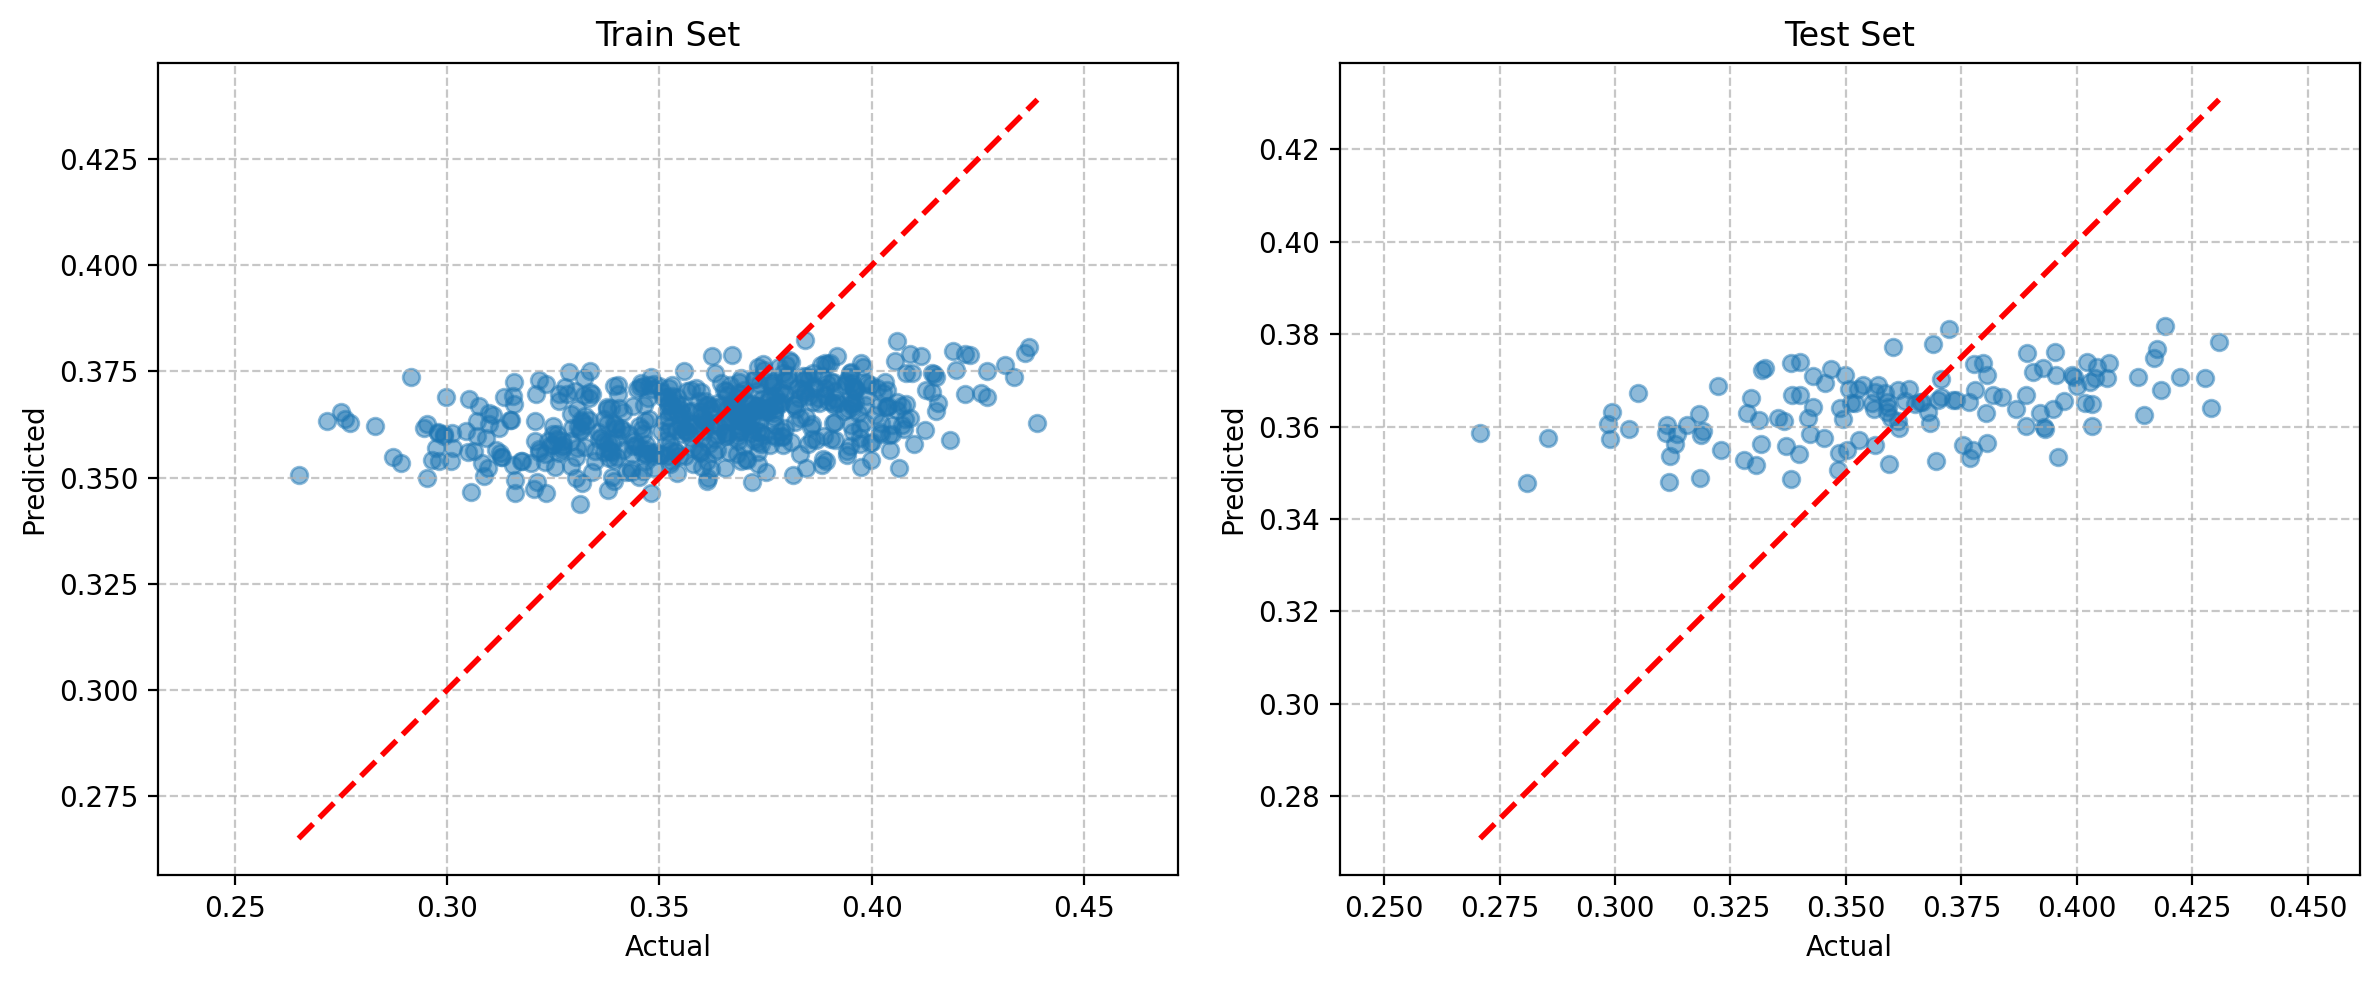

In [135]:
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_target = "S_Module11_Prolif_score" #"S_CHANG_CORE_SERUM_RESPONSE_UP" #'S_Buck14_score'
y_train_tg = Y_train_yjs[y_target]
y_test_tg = Y_test_yjs[y_target]

# Initialize and fit SVR model
model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit
model_svr.fit(X_train_yjs, y_train_tg)

# Predict
y_transformed_trainpred = model_svr.predict(X_train_yjs)
y_transformed_testpred = model_svr.predict(X_test_yjs)

# Create dummy DataFrames
y_trainpred_dummy_df = pd.DataFrame(0, index=X_train_yjs.index, columns=Y_train_yjs.columns)
y_trainpred_dummy_df[y_target] = y_transformed_trainpred

y_testpred_dummy_df = pd.DataFrame(0, index=X_test_yjs.index, columns=Y_test_yjs.columns)
y_testpred_dummy_df[y_target] = y_transformed_testpred

# Apply inverse transform
y_trainpred_dummy_df_inv = preprocess_pipeline_Y.inverse_transform(y_trainpred_dummy_df)
y_testpred_dummy_df_inv = preprocess_pipeline_Y.inverse_transform(y_testpred_dummy_df)

# Extract predictions
y_trainpred = y_trainpred_dummy_df_inv[y_target].to_numpy()
y_testpred = y_testpred_dummy_df_inv[y_target].to_numpy()

# Evaluate
train_r2 = r2_score(Y_train[y_target], y_trainpred)
test_r2 = r2_score(Y_test[y_target], y_testpred)
# print(test_r2)
train_rmse = np.sqrt(mean_squared_error(Y_train[y_target], y_trainpred))
test_rmse = np.sqrt(mean_squared_error(Y_test[y_target], y_testpred))
# print(test_rmse)
train_mae = mean_absolute_error(Y_train[y_target], y_trainpred)
test_mae = mean_absolute_error(Y_test[y_target], y_testpred)
# print(test_mae)
# Print results
print("SVR Model Performance:")
print(f"{'Metric':<10} {'Train':<10} {'Test':<10}")
print("-" * 30)
print(f"{'R2':<10} {train_r2:<10.4f} {test_r2:<10.4f}")
print(f"{'RMSE':<10} {train_rmse:<10.4f} {test_rmse:<10.4f}")
print(f"{'MAE':<10} {train_mae:<10.4f} {test_mae:<10.4f}")

# Plot actual vs predicted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(Y_train[y_target], y_trainpred, alpha=0.5)
ax1.plot([Y_train[y_target].min(), Y_train[y_target].max()], 
         [Y_train[y_target].min(), Y_train[y_target].max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Train Set')

ax2.scatter(Y_test[y_target], y_testpred, alpha=0.5)
ax2.plot([Y_test[y_target].min(), Y_test[y_target].max()], 
         [Y_test[y_target].min(), Y_test[y_target].max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Set')

# Add gridlines
ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)
# Make the plot square
ax1.axis('equal')
ax2.axis('equal')

plt.tight_layout()
plt.show()


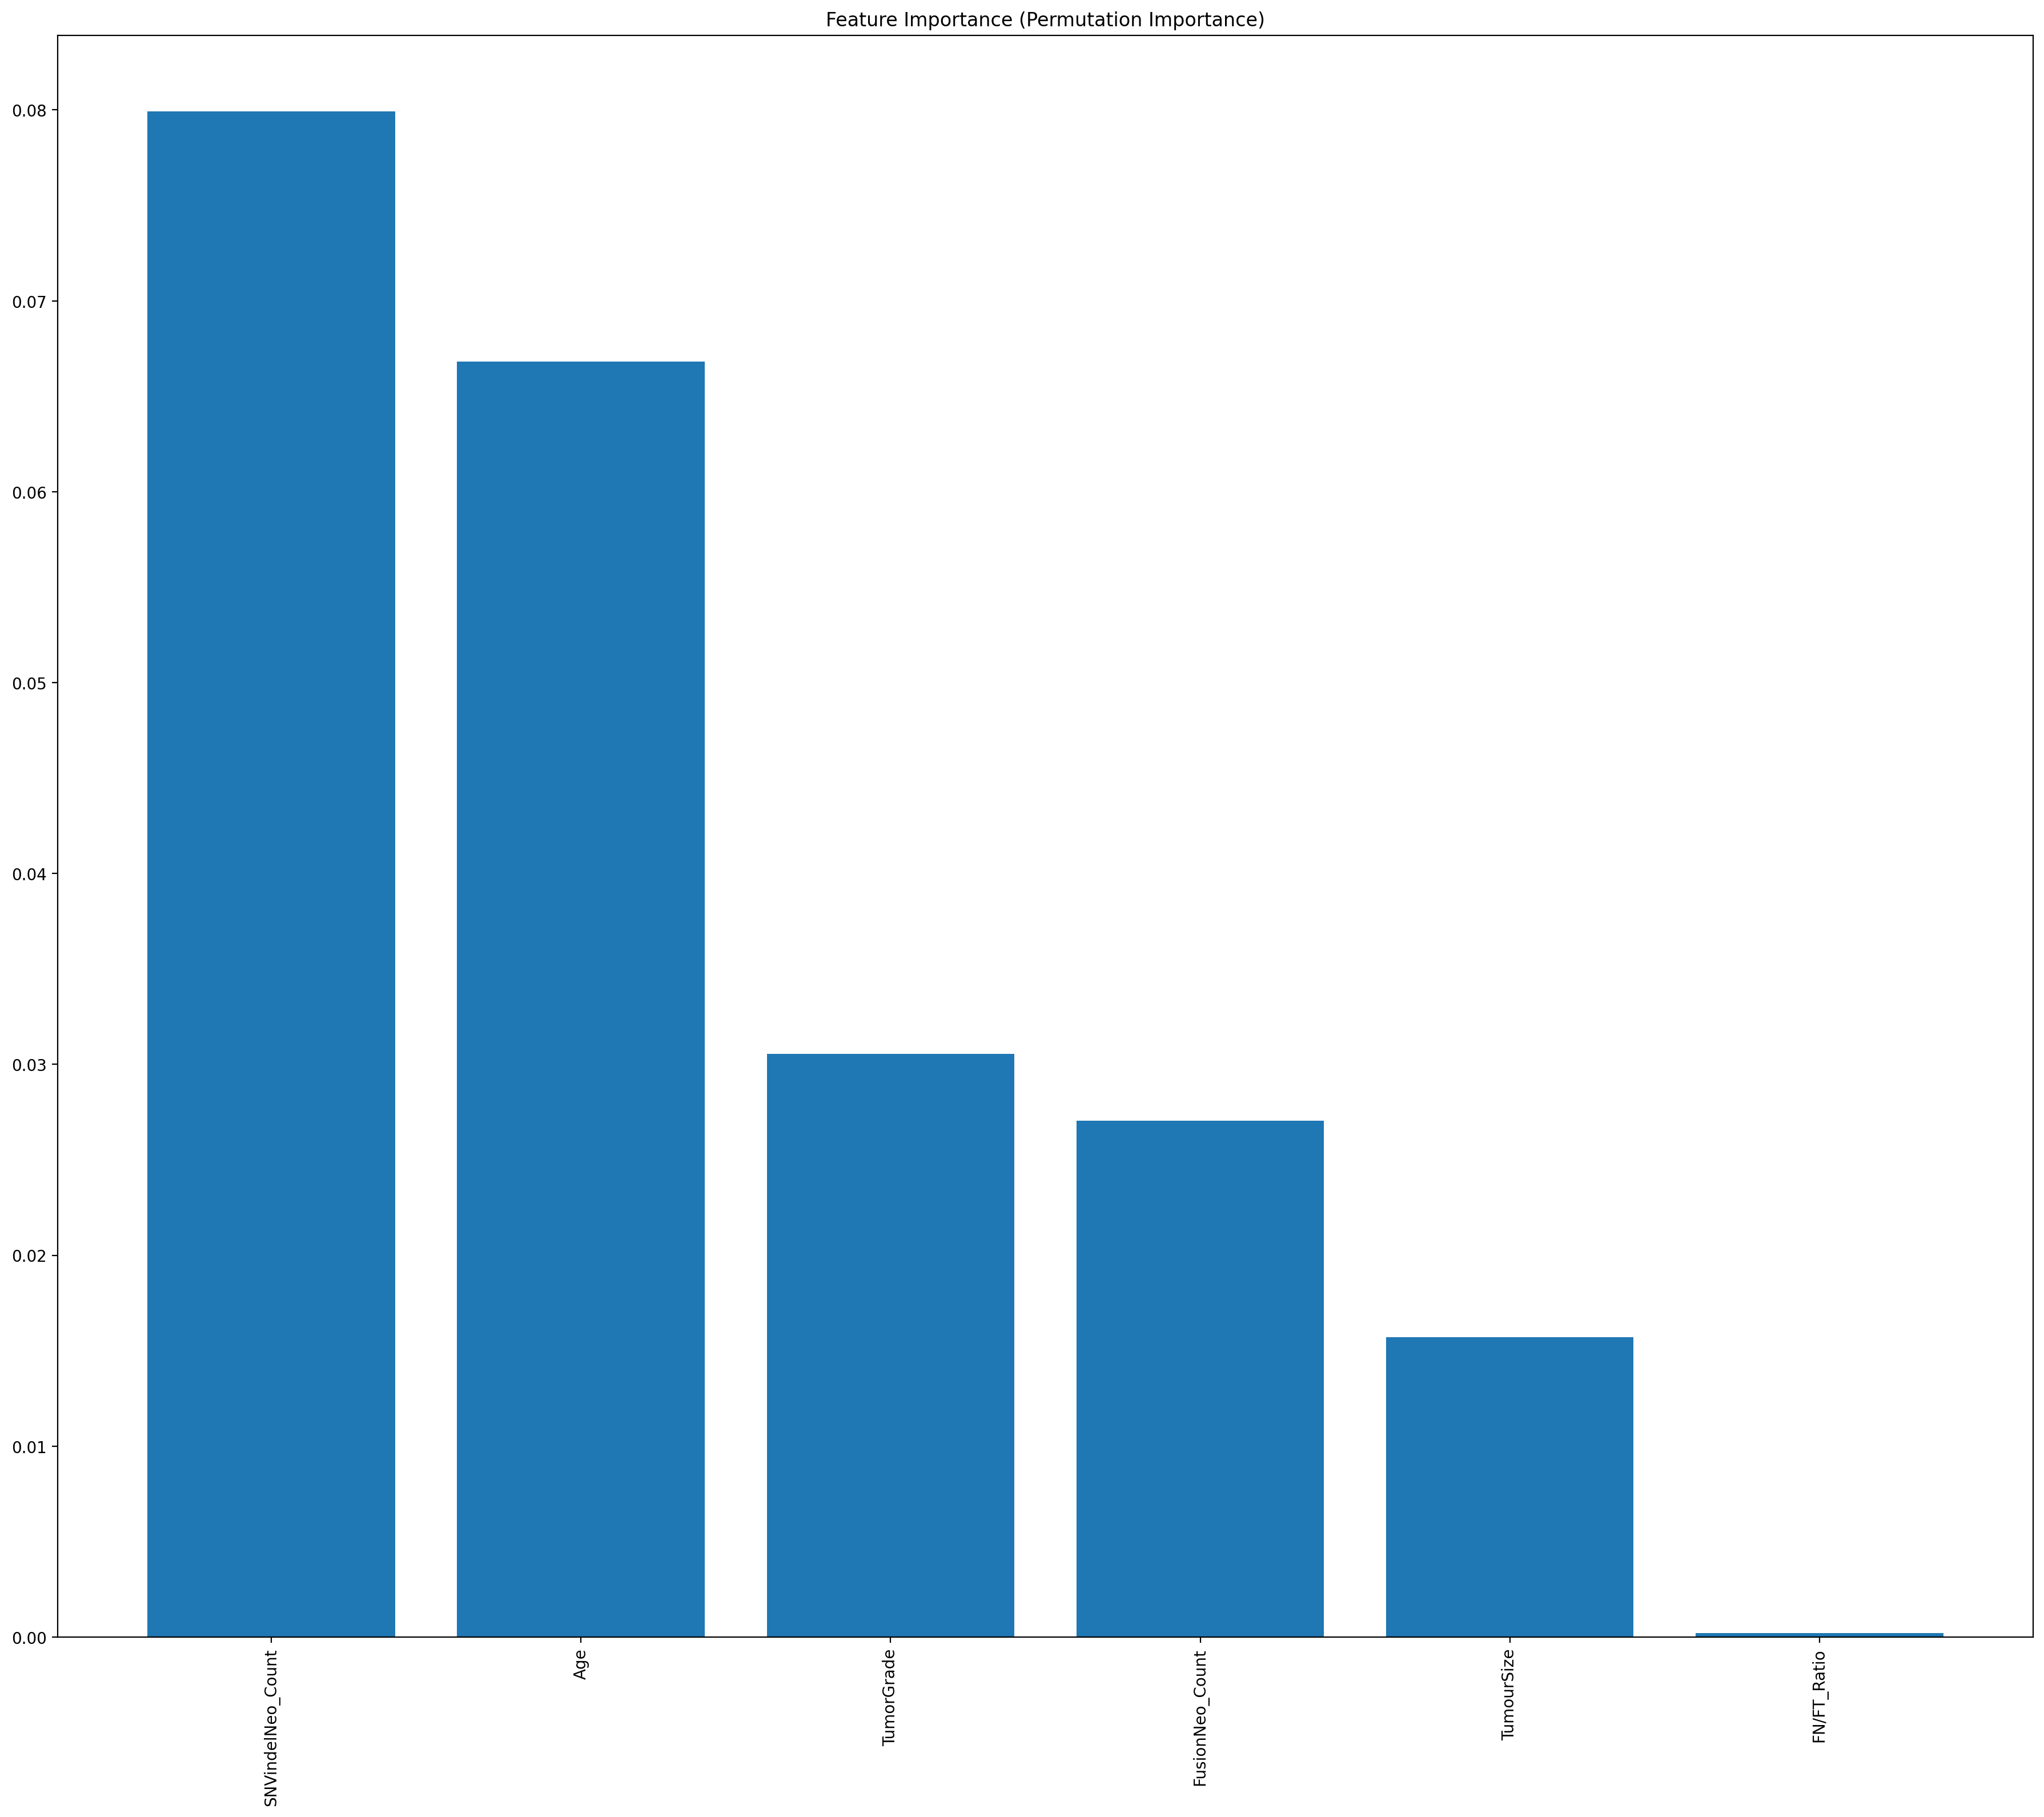

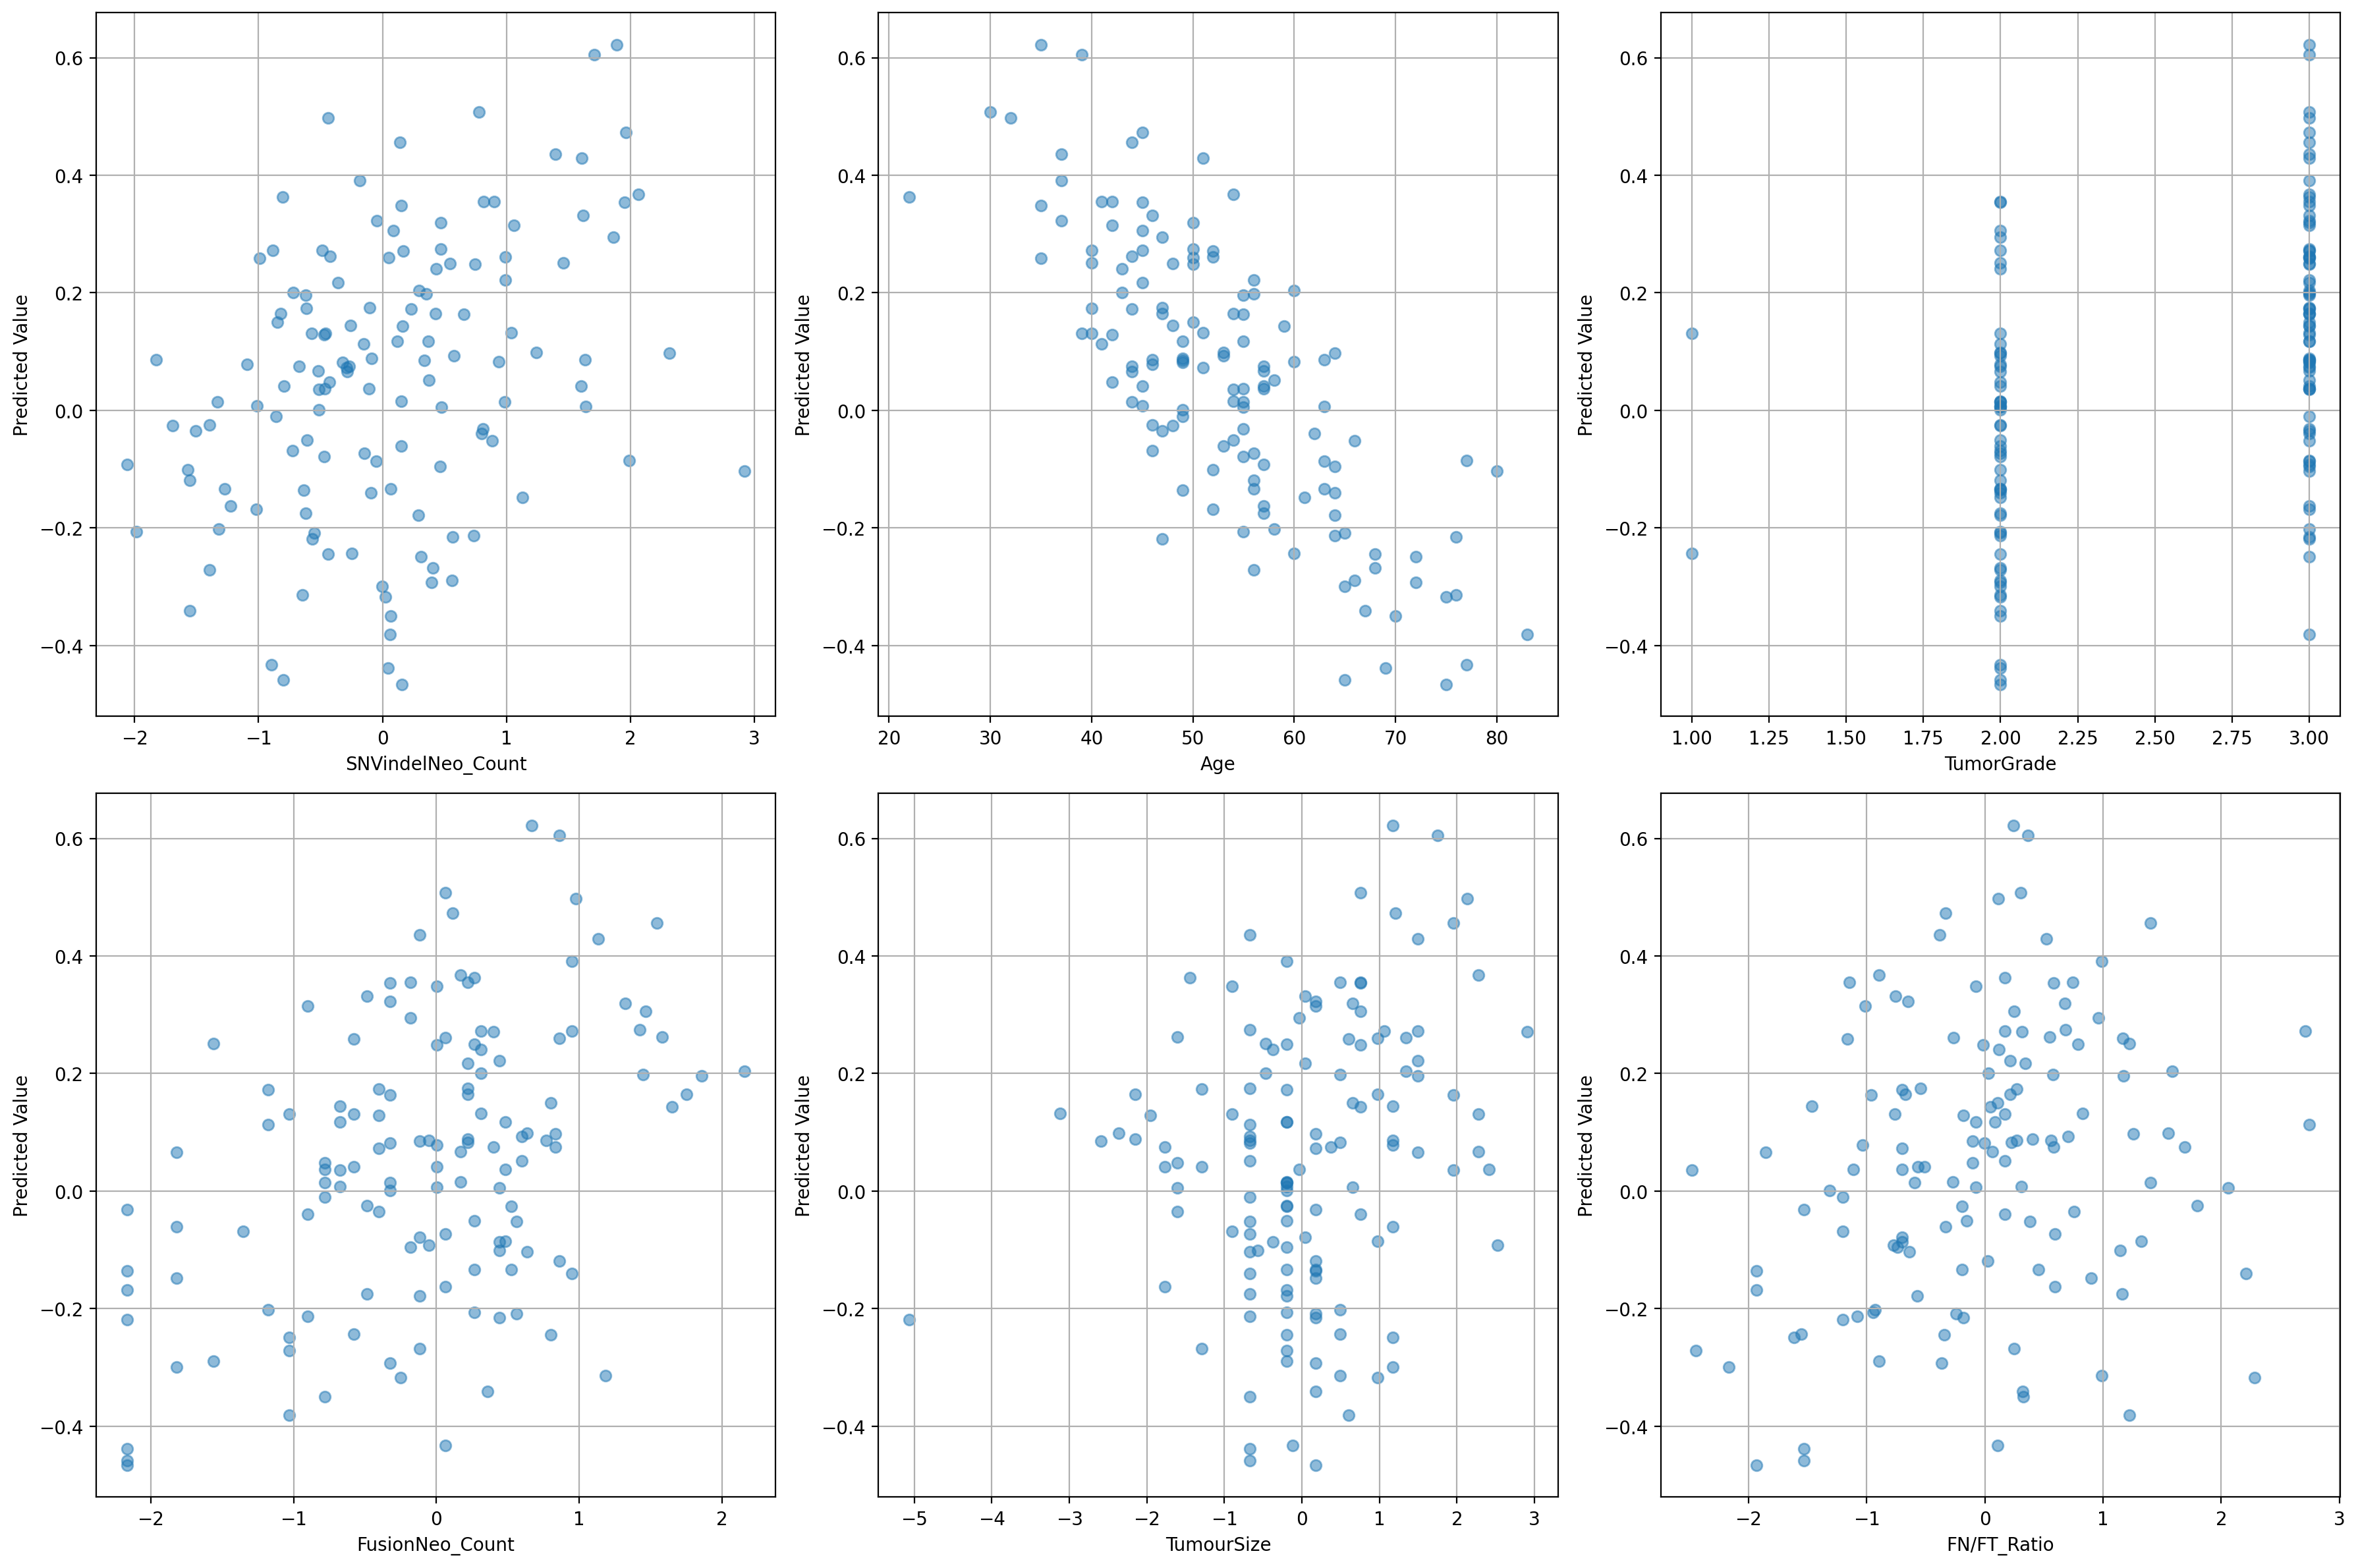

In [136]:
# Feature importance using permutation importance
result = permutation_importance(
    model_svr, X_test_yjs, y_test_tg,
    n_repeats=10,
    random_state=42
)

# Create feature importance plot
feature_importance = pd.DataFrame(
    {'feature': X_test_yjs.columns,
     'importance': result.importances_mean}
).sort_values('importance', ascending=False)

plt.figure(figsize=(18, 16))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance (Permutation Importance)')
plt.tight_layout()
plt.show()

# Simplified feature visualization
def plot_feature_relationships(X, y_pred, feature_names, n_features=6):
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature in enumerate(feature_names):
        if i >= n_features:
            break
            
        row = i // n_cols
        col = i % n_cols
        
        axes[row, col].scatter(X[feature], y_pred, alpha=0.5)
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Predicted Value')
        axes[row, col].grid(True)
    
    # Hide empty subplots
    for i in range(len(feature_names), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot relationships for top 6 important features
top_features = feature_importance['feature'].head(6).tolist()
plot_feature_relationships(X_test_yjs, y_transformed_testpred, top_features)

Actual: 0.3952, Predicted: 0.3761
Actual: 0.3318, Predicted: 0.3722
Actual: 0.3528, Predicted: 0.3571
Actual: 0.3995, Predicted: 0.3708
Actual: 0.3585, Predicted: 0.3672
Actual: 0.3365, Predicted: 0.3612
Actual: 0.2809, Predicted: 0.3478
Actual: 0.3588, Predicted: 0.3654
Actual: 0.3649, Predicted: 0.3648
Actual: 0.3371, Predicted: 0.3558


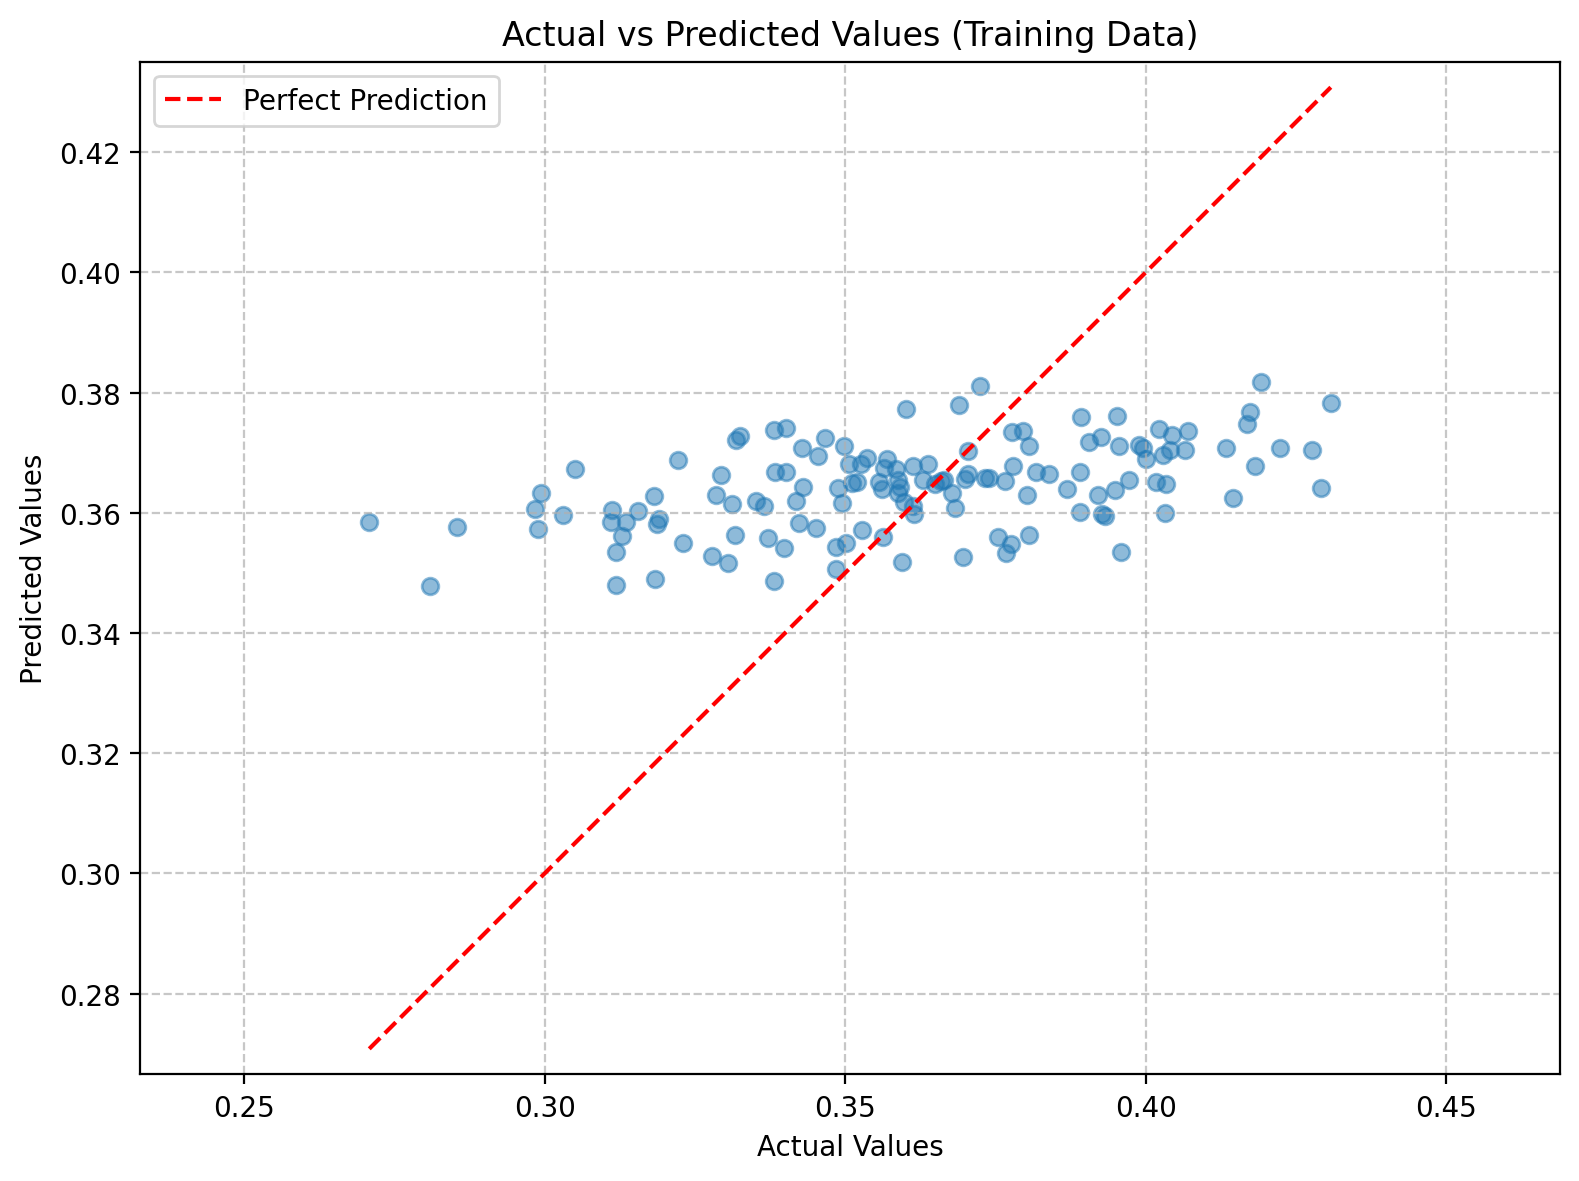

In [137]:
# Print a few actual vs predicted values
for actual, pred in zip(Y_test[y_target], y_testpred[:10]):
    print(f"Actual: {actual:.4f}, Predicted: {pred:.4f}")

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Y_test[y_target], y_testpred, alpha=0.5)

# Add the perfect prediction line (y=x)
plt.plot([Y_test[y_target].min(), Y_test[y_target].max()], [Y_test[y_target].min(), Y_test[y_target].max()], 
         'r--', label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Training Data)')
plt.legend()

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Make the plot square
plt.axis('equal')

plt.tight_layout()
plt.show()

#### **Iterative Learning over all Y labels**

The learning using SVR above was done on just one Y label. Let's put these into a set of functions so we can run this process iteratively on all Y columns we have set up.

First, set up a class for storing metrics.

In [138]:
class YTargetMetrics:
    def __init__(self, target_name, train_r2, test_r2, train_rmse, test_rmse, train_mae, test_mae):
        self.target_name = target_name
        self.train_r2 = train_r2
        self.test_r2 = test_r2
        self.train_rmse = train_rmse
        self.test_rmse = test_rmse
        self.train_mae = train_mae
        self.test_mae = test_mae

    def __str__(self):
        return f"""Model Performance for {self.target_name}:
{'Metric':<10} {'Train':<10} {'Test':<10}
{'-' * 30}
{'R2':<10} {self.train_r2:<10.4f} {self.test_r2:<10.4f}
{'RMSE':<10} {self.train_rmse:<10.4f} {self.test_rmse:<10.4f}
{'MAE':<10} {self.train_mae:<10.4f} {self.test_mae:<10.4f}"""

    def to_dict(self):
        return {
            'target_name': self.target_name,
            'train_r2': self.train_r2,
            'test_r2': self.test_r2,
            'train_rmse': self.train_rmse,
            'test_rmse': self.test_rmse,
            'train_mae': self.train_mae,
            'test_mae': self.test_mae
        }

Then, define functions.

In [139]:
import os
from typing import TypeVar, Dict

def run_svr_model(
   y_target: str,
   Y_train: pd.DataFrame,
   Y_test: pd.DataFrame,
   X_train_transformed: pd.DataFrame,
   X_test_transformed: pd.DataFrame,
   Y_train_transformed: pd.DataFrame,
   Y_test_transformed: pd.DataFrame,
   preprocess_pipeline_Y: Pipeline
) -> YTargetMetrics:
    """Run SVR model for a single target variable and return performance metrics.
    
    Args:
        y_target: Name of the target column
        Y_train: Original training dataframe with untransformed target variables
        Y_test: Original test dataframe with untransformed target variables 
        X_train_transformed: Transformed training features
        X_test_transformed: Transformed test features
        Y_train_transformed: Transformed training targets
        Y_test_transformed: Transformed test targets
        preprocess_pipeline_Y: Fitted preprocessing pipeline for target variables
    
    Returns:
        YTargetMetrics object containing model performance metrics
    """
    
    # assign untransformed, raw target data
    raw_y_train = Y_train[y_target]
    raw_y_test = Y_test[y_target]

    # Initialize and fit model
    model_instance = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model_instance.fit(X_train_transformed, Y_train_transformed[y_target])
    
    # predict
    y_transformed_train_pred = model_instance.predict(X_train_transformed)
    y_transformed_test_pred = model_instance.predict(X_test_transformed)

    # Create dummy DataFrames for inverse transform
    dummy_train_y = pd.DataFrame(0, index=X_train_transformed.index, 
                                columns=Y_train_transformed.columns)
    dummy_train_y[y_target] = y_transformed_train_pred

    dummy_test_y = pd.DataFrame(0, index=X_test_transformed.index, 
                               columns=Y_test_transformed.columns)
    dummy_test_y[y_target] = y_transformed_test_pred

    # apply inverse transform
    dummy_train_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_train_y)
    dummy_test_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_test_y)

    # Extract predictions
    y_train_pred = dummy_train_y_inv[y_target].to_numpy()
    y_test_pred = dummy_test_y_inv[y_target].to_numpy()

    # Calculate metrics
    train_r2 = r2_score(raw_y_train, y_train_pred)
    test_r2 = r2_score(raw_y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(raw_y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(raw_y_test, y_test_pred))
    train_mae = mean_absolute_error(raw_y_train, y_train_pred)
    test_mae = mean_absolute_error(raw_y_test, y_test_pred)

    # Plot actual vs predicted
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    # Training set plot
    ax1.scatter(raw_y_train, y_train_pred, alpha=0.5)
    ax1.plot([raw_y_train.min(), raw_y_train.max()], 
             [raw_y_train.min(), raw_y_train.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.set_title('Training Set')
    ax1.grid(True)

    # Test set plot
    ax2.scatter(raw_y_test, y_test_pred, alpha=0.5)
    ax2.plot([raw_y_test.min(), raw_y_test.max()], 
             [raw_y_test.min(), raw_y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_title('Testing Set')
    ax2.grid(True)

	# Add gridlines
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax2.grid(True, linestyle='--', alpha=0.7)
    # Make the plot square
    ax1.axis('equal')
    ax2.axis('equal')
    plt.tight_layout()

    # Create 'plots' directory if it doesn't exist
    os.makedirs(f'plots/{y_target}', exist_ok=True)
    plt.savefig(f'plots/{y_target}/{y_target}-SVR-def-model-performance-comparison.png')
    plt.close()

    # For SVR, instead of feature importance, we can plot feature coefficients 
    # if using linear kernel, or skip if using rbf kernel
    if model_instance.kernel == 'linear':
        _, ax = plt.subplots(figsize=(18, 16), dpi=300)
        coefficients = pd.Series(model_instance.coef_[0], 
                               index=X_train_transformed.columns)
        coefficients.sort_values(ascending=True).plot(kind='barh')
        plt.title('SVR Feature Coefficients (Linear Kernel)')
        plt.tight_layout()
        plt.savefig(f"plots/{y_target}/{y_target}-SVR-def-model-feature-coefficients.png")
        plt.close()

    print(f"Model training and evaluation for {y_target} completed.")

    return YTargetMetrics(y_target, train_r2, test_r2, train_rmse, test_rmse, 
                         train_mae, test_mae)

Run the function in a loop across all Y labels.

In [140]:
# Dictionary to store results for each target
results_dict = {}

# Loop through each target
for y_target in Y_labels_all:
    print(f"\nProcessing target: {y_target}")
    
    results = run_svr_model(
        y_target=y_target,
        Y_train=Y_train,
        Y_test=Y_test,
        X_train_transformed=X_train_yjs,
        X_test_transformed=X_test_yjs,
        Y_train_transformed=Y_train_yjs,
        Y_test_transformed=Y_test_yjs,
        preprocess_pipeline_Y=preprocess_pipeline_Y
    )
    
    # Store results
    results_dict[y_target] = results
    
    # Print individual results
    print(results)

# Optional: Create summary DataFrame of all results
summary_df = pd.DataFrame({
    target: results.to_dict() 
    for target, results in results_dict.items()
}).T

# Print overall summary
print("\nOverall Summary:")


# Optionally save results
# summary_df.to_csv('svr_model_results.csv')


Processing target: ESTIMATE
Model training and evaluation for ESTIMATE completed.
Model Performance for ESTIMATE:
Metric     Train      Test      
------------------------------
R2         0.0256     0.0142    
RMSE       1331.9091  1281.4370 
MAE        1091.3778  1035.2017 

Processing target: IMPRES
Model training and evaluation for IMPRES completed.
Model Performance for IMPRES:
Metric     Train      Test      
------------------------------
R2         0.0139     0.0053    
RMSE       1.3415     1.3270    
MAE        1.0597     1.0375    

Processing target: C_Bcellsnaive
Model training and evaluation for C_Bcellsnaive completed.
Model Performance for C_Bcellsnaive:
Metric     Train      Test      
------------------------------
R2         0.0280     0.0358    
RMSE       0.0506     0.0510    
MAE        0.0391     0.0399    

Processing target: C_TcellsCD4memoryresting
Model training and evaluation for C_TcellsCD4memoryresting completed.
Model Performance for C_TcellsCD4memoryres

In [141]:
show(summary_df, maxBytes=0)

#### **Iterative Learning over Y Labels with `GridSearchCV` for Hyperparameter Tuning**

Now we can rewrite the functions to incorporate `GridSearchCV`.

In [142]:
from sklearn.model_selection import GridSearchCV

def run_svr_model_gridsearch(
    y_target: str,
    Y_train: pd.DataFrame,
    Y_test: pd.DataFrame,
    X_train_transformed: pd.DataFrame,
    X_test_transformed: pd.DataFrame,
    Y_train_transformed: pd.DataFrame,
    Y_test_transformed: pd.DataFrame,
    preprocess_pipeline_Y: Pipeline
) -> YTargetMetrics:
    """Run SVR model with GridSearchCV for a single target variable and return performance metrics."""

    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }

    # Initialize base model
    base_model = SVR()

    # Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    # Fit GridSearchCV
    print(f"\nPerforming GridSearchCV for {y_target}...")
    grid_search.fit(X_train_transformed, Y_train_transformed[y_target])

    # Print best parameters
    print(f"\nBest parameters for {y_target}:")
    print(grid_search.best_params_)

    # Use best model for predictions
    model_instance = grid_search.best_estimator_
    
    # Get predictions (transformed space)
    y_train_pred_transformed = model_instance.predict(X_train_transformed)
    y_test_pred_transformed = model_instance.predict(X_test_transformed)

    # Create dummy DataFrames for inverse transform
    dummy_train_y = pd.DataFrame(0, index=X_train_transformed.index, 
                                columns=Y_train_transformed.columns)
    dummy_train_y[y_target] = y_train_pred_transformed

    dummy_test_y = pd.DataFrame(0, index=X_test_transformed.index, 
                               columns=Y_test_transformed.columns)
    dummy_test_y[y_target] = y_test_pred_transformed

    # Inverse transform predictions
    dummy_train_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_train_y)
    dummy_test_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_test_y)

    # Extract the relevant target column
    y_train_pred = dummy_train_y_inv[y_target].to_numpy()
    y_test_pred = dummy_test_y_inv[y_target].to_numpy()

    # Get raw target data
    raw_y_train = Y_train[y_target]
    raw_y_test = Y_test[y_target]

    # Calculate metrics
    train_r2 = r2_score(raw_y_train, y_train_pred)
    test_r2 = r2_score(raw_y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(raw_y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(raw_y_test, y_test_pred))
    train_mae = mean_absolute_error(raw_y_train, y_train_pred)
    test_mae = mean_absolute_error(raw_y_test, y_test_pred)

    # Create plots directory
    os.makedirs(f'plots/{y_target}', exist_ok=True)

    # Plot CV results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cv_results['param_C'], -cv_results['mean_test_score'], 'o-')
    plt.xlabel('C parameter')
    plt.ylabel('Mean Squared Error')
    plt.xscale('log')
    
    plt.subplot(1, 2, 2)
    plt.plot(cv_results['param_epsilon'], -cv_results['mean_test_score'], 'o-')
    plt.xlabel('Epsilon parameter')
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()
    plt.savefig(f'plots/{y_target}/{y_target}-SVR-grid-search-results.png')
    plt.close()

    # Plot actual vs predicted
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    ax1.scatter(raw_y_train, y_train_pred, alpha=0.5)
    ax1.plot([raw_y_train.min(), raw_y_train.max()], 
             [raw_y_train.min(), raw_y_train.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.set_title('Training Set')
    ax1.grid(True)

    ax2.scatter(raw_y_test, y_test_pred, alpha=0.5)
    ax2.plot([raw_y_test.min(), raw_y_test.max()], 
             [raw_y_test.min(), raw_y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_title('Testing Set')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'plots/{y_target}/{y_target}-SVR-tuned-model-performance-comparison.png')
    plt.close()

    # Create results object with additional grid search info
    results = YTargetMetrics(y_target, train_r2, test_r2, train_rmse, test_rmse, train_mae, test_mae)
    
    # Add grid search results to dictionary
    grid_search_results = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back from negative MSE
        'cv_results': grid_search.cv_results_
    }

    return results, grid_search_results

# Modified function to handle multiple targets
def run_svr_for_multiple_targets(
    y_columns: list[str],
    Y_train: pd.DataFrame,
    Y_test: pd.DataFrame,
    X_train_transformed: pd.DataFrame,
    X_test_transformed: pd.DataFrame,
    Y_train_transformed: pd.DataFrame,
    Y_test_transformed: pd.DataFrame,
    preprocess_pipeline_Y: Pipeline
) -> Dict[str, tuple[YTargetMetrics, dict]]:
    
    results_dict = {}
    
    for y_target in y_columns:
        try:
            print(f"\nProcessing target: {y_target}")
            
            metrics, grid_results = run_svr_model_gridsearch(
                y_target=y_target,
                Y_train=Y_train,
                Y_test=Y_test,
                X_train_transformed=X_train_transformed,
                X_test_transformed=X_test_transformed,
                Y_train_transformed=Y_train_transformed,
                Y_test_transformed=Y_test_transformed,
                preprocess_pipeline_Y=preprocess_pipeline_Y
            )
            
            results_dict[y_target] = (metrics, grid_results)
            print(f"\nResults for {y_target}:")
            print(metrics)
            print("\nBest parameters:", grid_results['best_params'])
            print("Best CV score (RMSE):", np.sqrt(grid_results['best_score']))
            
        except Exception as e:
            print(f"Error processing {y_target}: {str(e)}")
            continue
    
    return results_dict

# Usage:
Y_columns = Y_labels_all
all_results = run_svr_for_multiple_targets(
    y_columns=Y_columns,
    Y_train=Y_train,
    Y_test=Y_test,
    X_train_transformed=X_train_yjs,
    X_test_transformed=X_test_yjs,
    Y_train_transformed=Y_train_yjs,
    Y_test_transformed=Y_test_yjs,
    preprocess_pipeline_Y=preprocess_pipeline_Y
)

# Create summary DataFrame with best parameters
summary_dict = {
    target: {
        **metrics.to_dict(),
        **{'best_' + k: v for k, v in grid_results['best_params'].items()}
    }
    for target, (metrics, grid_results) in all_results.items()
}

summary_df = pd.DataFrame.from_dict(summary_dict, orient='index')
print("\nOverall Summary:")


Processing target: ESTIMATE

Performing GridSearchCV for ESTIMATE...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for ESTIMATE:
{'C': 10, 'epsilon': 0.2, 'gamma': 0.01}

Results for ESTIMATE:
Model Performance for ESTIMATE:
Metric     Train      Test      
------------------------------
R2         0.2509     0.0975    
RMSE       1167.8322  1226.1002 
MAE        912.5775   1016.0357 

Best parameters: {'C': 10, 'epsilon': 0.2, 'gamma': 0.01}
Best CV score (RMSE): 0.9696583555369181

Processing target: IMPRES

Performing GridSearchCV for IMPRES...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for IMPRES:
{'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}

Results for IMPRES:
Model Performance for IMPRES:
Metric     Train      Test      
------------------------------
R2         0.0618     -0.0298   
RMSE       1.3085     1.3502    
MAE        1.0389     1.0668    

Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}

In [143]:
show(summary_df)

In [144]:
# get the list from the dict
activator_t = imscore_series_dict['activator_T']
suppressor_t = imscore_series_dict['suppressor_T']
best_prog = imscore_series_dict['HR<1_best_10_prog']
worst_prog = imscore_series_dict['HR>1_worst_10_prog']

# merge
merged_cols = activator_t + suppressor_t + best_prog + worst_prog
merged_cols = list(set(merged_cols))
print(f"Total number of elements in merged_cols (unsorted): {len(merged_cols)}")

# there are repeated immune scores (at least in between two groups, can be more than two groups) so get a list of them first
from itertools import combinations
# list of all the sets
all_sets = [set(activator_t), set(suppressor_t), set(best_prog), set(worst_prog)]

# Get all possible combinations of 2 sets
set_combo = combinations(all_sets, 2)

# Find the union of all set combinations
union_of_combo = list(set.union(*[set.intersection(c1, c2) for c1, c2 in set_combo]))

print(f"Elements that overlap between at least two sets: {union_of_combo}")

# rearrange the list element order based on another list
merged_cols = ["ESTIMATE"] + union_of_combo + [x for x in activator_t if x not in union_of_combo] + [x for x in suppressor_t if x not in union_of_combo] + [x for x in best_prog if x not in union_of_combo] + [x for x in worst_prog if x not in union_of_combo]

print(f"Total number of elements in merged_cols (sorted by original X feature order and groups): {len(merged_cols)}")


Total number of elements in merged_cols (unsorted): 45
Elements that overlap between at least two sets: ['S_TGFB_PCA_17349583', 'S_TGFB_score_21050467', 'S_T_helper', 'S_TFH']
Total number of elements in merged_cols (sorted by original X feature order and groups): 46


In [145]:
print(merged_cols)

['ESTIMATE', 'S_TGFB_PCA_17349583', 'S_TGFB_score_21050467', 'S_T_helper', 'S_TFH', 'S_T_cells', 'S_Tcell_receptors_score', 'S_Tcell_21978456', 'S_CD8_Tcells', 'S_CD8A', 'S_Th17', 'S_Tcm', 'S_Tem', 'S_Th1', 'S_Cytotoxic_cells', 'C_TcellsCD4memoryresting', 'S_T_cell_PCA_16704732', 'S_Attractors_G_CD3E', 'S_Tgd', 'S_CD8_PCA_16704732', 'S_Module4_TcellBcell_score', 'S_Module5_TcellBcell_score', 'S_CD8_CD68_ratio', 'S_ICR_SCORE', 'S_ICR_ACT_SCORE', 'S_GRANS_PCA_16704732', 'S_Treg', 'S_CTLA4_data', 'S_PD1_data', 'S_PDL1_data', 'S_PD1_PDL1_score', 'S_IL4_score_21050467', 'S_IL13_score_21050467', 'S_TcClassII_score', 'S_KEGG_TGF_Beta', 'S_ICR_INHIB_SCORE', 'S_Buck14_score', 'S_Bcell_receptors_score', 'S_CD103pos_mean_25446897', 'S_Attractors_G_SLAMF6', 'S_ICS5_score', 'S_Lymph_Vessels', 'S_Rotterdam_ERneg_PCA_15721472', 'S_IFNG_score_21050467', 'S_Module11_Prolif_score', 'S_TREM1_data']


Rerun the grid search using the subset of Y labels. 

In [146]:
Y_columns = merged_cols
all_results = run_svr_for_multiple_targets(
    y_columns=Y_columns,
    Y_train=Y_train,
    Y_test=Y_test,
    X_train_transformed=X_train_yjs,
    X_test_transformed=X_test_yjs,
    Y_train_transformed=Y_train_yjs,
    Y_test_transformed=Y_test_yjs,
    preprocess_pipeline_Y=preprocess_pipeline_Y
)

# Create summary DataFrame with best parameters
summary_dict_ss = {
    target: {
        **metrics.to_dict(),
        **{'best_' + k: v for k, v in grid_results['best_params'].items()}
    }
    for target, (metrics, grid_results) in all_results.items()
}

summary_df_ss = pd.DataFrame.from_dict(summary_dict_ss, orient='index')
print("\nOverall Summary:")


Processing target: ESTIMATE

Performing GridSearchCV for ESTIMATE...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for ESTIMATE:
{'C': 10, 'epsilon': 0.2, 'gamma': 0.01}

Results for ESTIMATE:
Model Performance for ESTIMATE:
Metric     Train      Test      
------------------------------
R2         0.2509     0.0975    
RMSE       1167.8322  1226.1002 
MAE        912.5775   1016.0357 

Best parameters: {'C': 10, 'epsilon': 0.2, 'gamma': 0.01}
Best CV score (RMSE): 0.9696583555369181

Processing target: S_TGFB_PCA_17349583

Performing GridSearchCV for S_TGFB_PCA_17349583...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for S_TGFB_PCA_17349583:
{'C': 10, 'epsilon': 0.1, 'gamma': 'scale'}

Results for S_TGFB_PCA_17349583:
Model Performance for S_TGFB_PCA_17349583:
Metric     Train      Test      
------------------------------
R2         0.0233     -0.1089   
RMSE       0.0147     0.0150    
MAE        0.0113     0.0119   

In [147]:
show(summary_df_ss)